In [2]:
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.nn.init import *
from torchvision import transforms, utils, datasets, models
from models.inception_resnet_v1 import InceptionResnetV1
from mtcnn.mtcnn import MTCNN
import cv2
from PIL import Image
from pdb import set_trace
import time
import copy
from pathlib import Path
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage import io, transform
from tqdm import trange, tqdm
import csv
import glob
import dlib
import pandas as pd
import numpy as np

c:\Users\Hari Krishna\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


preprocessing

img croping before preprocessing

In [3]:
img_path= r'E:\Hari\sem6\minor project\minor project proposal\BCTMinorProject\CODE\data\crop me\train\Hari Krishna Khuju\20230208_124848.jpg'
image = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_rgb.shape

(4000, 3000, 3)

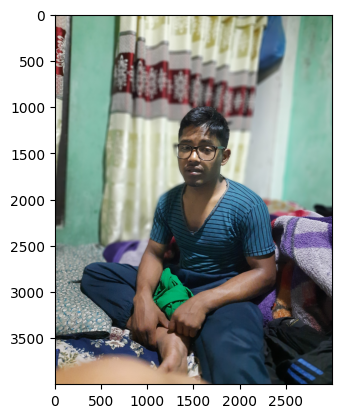

In [4]:
plt.imshow(image_rgb)

In [5]:
target_size=(160,160)

# Function to detect faces and crop images
def detect_and_crop(image_path, output_folder):
    # Load image
    image = cv2.imread(image_path)

    # Convert to RGB (MTCNN requires RGB format)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Detect faces
    detector = MTCNN()
    faces = detector.detect_faces(image_rgb)

    # Crop and save faces
    for i, face_info in enumerate(faces):
        x, y, width, height = face_info['box']
        # x=x+int(-0.2*x)
        # y=y+int(-0.6*y)
        # width=width+int(0.6*width)
        # height=height+int(0.6*height)
        face = image[y:y+height, x:x+width]
        output_path = os.path.join(output_folder, f"face_{i+1}_{os.path.basename(image_path)}")
        face = cv2.resize(face, target_size)
        cv2.imwrite(output_path, face)

# Main function to process all images in a directory
        
def process_images_in_directory(input_folder, output_folder):
    # Loop through subdirectories in the input folder
    for subdir, _, files in os.walk(input_folder):
        # Skip the root directory
        if subdir == input_folder:
            continue

        # Create corresponding subdirectory in the output folder
        relative_path = os.path.relpath(subdir, input_folder)
        output_subdirectory = os.path.join(output_folder, relative_path)
        os.makedirs(output_subdirectory, exist_ok=True)

        # Process images in the current subdirectory
        for file in files:
            # Check if the file is an image (you can add more extensions if needed)
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(subdir, file)
                detect_and_crop(image_path, output_subdirectory)

# Replace 'traindataset' and 'output_folder' with your actual folder names
input_folder = r'E:\Hari\sem6\minor project\minor project proposal\BCTMinorProject\CODE\data\crop me\train'
output_folder = r'E:\Hari\sem6\minor project\minor project proposal\BCTMinorProject\CODE\data\test_me\train'
#input_folder = r'E:\Hari\sem6\minor project\minor project proposal\BCTMinorProject\CODE\data\crop me\val'
#output_folder = r'E:\Hari\sem6\minor project\minor project proposal\BCTMinorProject\CODE\data\test_me\val'

process_images_in_directory(input_folder, output_folder)

1/1 [==============================] - 0s 223ms/step


image after preprocessing

In [6]:
img_path= r'E:\Hari\sem6\minor project\minor project proposal\BCTMinorProject\CODE\data\test_me\train\Hari Krishna Khuju\face_1_20230208_124848.jpg'
image = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_rgb.shape

(160, 160, 3)

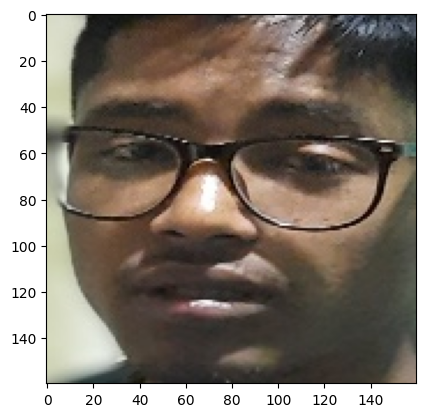

In [7]:
plt.imshow(image_rgb)

In [12]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir = 'data/test_me'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=8, 
                                             shuffle=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes
class_names

['Hari Krishna Khuju']

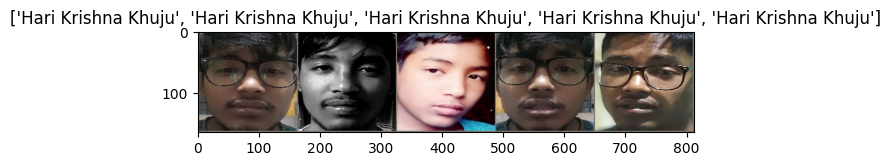

In [13]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [32]:
model_ft = InceptionResnetV1(pretrained='vggface2', classify=False, num_classes = len(class_names))

In [33]:
list(model_ft.children())[-6:]

[Block8(
   (branch0): BasicConv2d(
     (conv): Conv2d(1792, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU()
   )
   (branch1): Sequential(
     (0): BasicConv2d(
       (conv): Conv2d(1792, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
     )
     (1): BasicConv2d(
       (conv): Conv2d(192, 192, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1), bias=False)
       (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
     )
     (2): BasicConv2d(
       (conv): Conv2d(192, 192, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0), bias=False)
       (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
     )
   )
   (conv2d): Conv2d(384, 1792,

In [34]:
layer_list = list(model_ft.children())[-5:] # all final layers
layer_list

[AdaptiveAvgPool2d(output_size=1),
 Dropout(p=0.6, inplace=False),
 Linear(in_features=1792, out_features=512, bias=False),
 BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=512, out_features=8631, bias=True)]

In [35]:
model_ft = nn.Sequential(*list(model_ft.children())[:-5])

In [36]:
list(model_ft.children())

[BasicConv2d(
   (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
   (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU()
 ),
 BasicConv2d(
   (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
   (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU()
 ),
 BasicConv2d(
   (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU()
 ),
 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
 BasicConv2d(
   (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU()
 ),
 BasicConv2d(
   (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
   (bn): BatchNorm2d(192, ep

In [37]:
for param in model_ft.parameters():
    param.requires_grad = False

In [39]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x
class normalize(nn.Module):
    def __init__(self):
        super(normalize, self).__init__()
        
    def forward(self, x):
        x = F.normalize(x, p=2, dim=1)
        return x

adding above flatten class and normalize class

In [46]:
model_ft.avgpool_1a = nn.AdaptiveAvgPool2d(output_size=1)
model_ft.last_linear = nn.Sequential(
    Flatten(),
    nn.Linear(in_features=1792, out_features=512, bias=False),
    normalize()
)
#model_ft.logits = nn.Linear(layer_list[3].in_features, len(class_names))
# model_ft.softmax = nn.Softmax(dim=1)
# model_ft = model_ft.to(device)
# criterion = nn.CrossEntropyLoss()
# # Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-2, momentum=0.9)
# # Decay LR by a factor of *gamma* every *step_size* epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [47]:
list(model_ft.children())

[BasicConv2d(
   (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
   (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU()
 ),
 BasicConv2d(
   (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
   (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU()
 ),
 BasicConv2d(
   (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU()
 ),
 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
 BasicConv2d(
   (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU()
 ),
 BasicConv2d(
   (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
   (bn): BatchNorm2d(192, ep